# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

In [1]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.6/575.6 KB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 32.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=292b6ad1ccb7cef809e8cd81b68e2dcb5019205fb3c0d8f04d3035ad8973c9c8
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


### 1-2. 라이브러리 import

In [2]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget,os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import wget,os

### 1-3. 한글 글꼴 설정(Windows)

In [3]:
if not os.path.exists("malgun.ttf"): 
    wget.download("https://www.wfonts.com/download/data/2016/06/13/malgun-gothic/malgun.ttf")
if 'malgun' not in fm.fontManager.findfont("Malgun Gothic"):
    fm.fontManager.addfont("malgun.ttf")
if plt.rcParams['font.family']!= ["Malgun Gothic"]:
    plt.rcParams['font.family']= [font for font in fm.fontManager.ttflist if 'malgun.ttf' in font.fname][-1].name
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
assert plt.rcParams['font.family'] == ["Malgun Gothic"], "한글 폰트가 설정되지 않았습니다."
FONT_PATH = "malgun.ttf"

HTTPError: ignored

In [4]:
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,322 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122349 files and di

### 1-4. 자바 경로 설정(Windows)

In [5]:
os.environ['JAVA_HOME'] = "C:\Program Files\Java\jdk-19"

### 1-3. 한글 글꼴 설정(Colab)

In [6]:
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [7]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결(Colab)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 전처리한 데이터 불러오기
* 1, 2일차에 전처리한 데이터를 불러옵니다.
* sparse data에 대해서는 scipy.sparse.load_npz 활용

In [15]:
import scipy.sparse

path = '/content/drive/MyDrive/2023.04.03_미니프로젝트4차_실습자료/'

# pr -> w2v
x_pr_train = np.load(path + "X_pr_train.npy")
x_pr_val = np.load(path + "X_pr_val.npy")

# mor_sequence -> Sequence
x_mor_sequence_train = np.load(path + "X_mor_sequence_train.npy")
x_mor_sequence_val = np.load(path + "X_mor_sequence_val.npy")

# tfidf -> N-gram -> sparse
# .npz 파일에서 희소 행렬 데이터를 불러옴
x_tfidf_train = scipy.sparse.load_npz(path + "X_tfidf_train.npz")
x_tfidf_val = scipy.sparse.load_npz(path + "X_tfidf_val.npz")
# 행렬을 배열화
x_tfidf_train = x_tfidf_train.toarray()
x_tfidf_val = x_tfidf_val.toarray()

# # 0이 아닌 요소의 인덱스를 추출
# sparse_matrix = sp.load_npz('your_file.npz')
# nonzero_indices = sparse_matrix.nonzero()

In [16]:
x_pr_train

array([[ 0.31590134, -0.32537133, -0.7203466 , ...,  0.5739513 ,
        -0.4016488 , -0.12247835],
       [-0.03829222,  0.65330553, -0.24798286, ...,  0.44637606,
         0.05009526,  0.13264766],
       [ 0.13402383,  0.20593716, -0.2238828 , ...,  0.9318299 ,
        -0.00994976, -0.05068248],
       ...,
       [ 0.11617593,  0.23921092, -0.8226077 , ...,  0.08719417,
        -0.19894451, -0.07889563],
       [-0.03684868, -0.01131414, -0.04355419, ...,  0.7841752 ,
        -0.14284861, -0.25371662],
       [ 0.30445954, -0.04583384, -0.20980749, ...,  0.4586243 ,
        -0.35916278, -0.51268154]], dtype=float32)

In [17]:
x_tfidf_train.nonzero()

(array([   0,    0,    0, ..., 2593, 2593, 2593]),
 array([1299, 4164, 4356, ..., 9357, 9470, 9605]))

In [18]:
x_tfidf_val.nonzero()

(array([   0,    0,    0, ..., 1111, 1111, 1111]),
 array([ 306,  332,  651, ..., 8228, 8666, 9543]))

In [19]:
import scipy
tfidf_train = scipy.sparse.load_npz(path + 'X_tfidf_train.npz')
tfidf_val = scipy.sparse.load_npz(path + 'X_tfidf_val.npz')

X_tfidf_train = tfidf_train.toarray()
X_tfidf_val = tfidf_val.toarray()

In [ ]:
X_tfidf_train[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
# y_train과 y_val 불러오기"
y_train = pd.read_csv(path+'y_train.csv')['label']
y_val = pd.read_csv(path+'y_train.csv')['label']

In [ ]:
y_train

0       1
1       1
2       2
3       1
4       1
       ..
2589    3
2590    1
2591    1
2592    2
2593    0
Name: label, Length: 2594, dtype: int64

In [ ]:
y_val

0       1
1       1
2       2
3       1
4       1
       ..
2589    3
2590    1
2591    1
2592    2
2593    0
Name: label, Length: 2594, dtype: int64

In [ ]:
# ## One-Hot Encoding
# from tensorflow.keras.utils import to_categorical

# class_n = len(np.unique(y_train))
# y_train = to_categorical(y_train, class_n)
# y_val = to_categorical(y_val, class_n)

In [ ]:
y_train

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train.shape, y_val.shape

((2594,), (2594,))

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# y_train = y_train.reshape(-1)  # 1차원 배열로 변환
# y_train = le.fit_transform(y_train)

# y_val = y_val.reshape(-1)  # 1차원 배열로 변환
# y_val = le.fit_transform(y_val)

In [ ]:
# y_train.shape, y_val.shape


((25940,), (25940,))

## 3. Machine Learning(N-grams)
* N-gram으로 전처리한 데이터를 이용하여 3개 이상의 Machine Learning 모델 학습 및 성능 분석
> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

### 3-1. Model 1 - w2v

In [21]:
# KNN, SVC를 위해
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# StandardScaler를 이용한 정규화
scaler = StandardScaler()
x_pr_train_re = scaler.fit_transform(x_pr_train)
x_mor_sequence_train_re = scaler.fit_transform(x_mor_sequence_train)
x_tfidf_train_re = scaler.fit_transform(x_tfidf_train)


In [22]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [23]:
# 모델 선언
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()
dt_model = DecisionTreeClassifier(random_state=777)
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
lr_model = LogisticRegression()
svc_model = SVC()

In [25]:
# 모델 학습
xgb_model.fit(x_pr_train, y_train)
lgbm_model.fit(x_pr_train, y_train)
dt_model.fit(x_pr_train, y_train)
rf_model.fit(x_pr_train, y_train)
knn_model.fit(x_pr_train_re, y_train)
lr_model.fit(x_pr_train, y_train)
svc_model.fit(x_pr_train_re, y_train)

XGBoostError: ignored

In [ ]:
# # 성능 예측
# xgb_cv_score = cross_val_score(xgb_model, x_pr_train, y_train, cv=10)
# lgbm_cv_score = cross_val_score(lgbm_model, x_pr_train, y_train, cv=10)
# dt_cv_score = cross_val_score(dt_model, x_pr_train, y_train, cv=10)
# rf_cv_score = cross_val_score(rf_model, x_pr_train, y_train, cv=10)
# knn_cv_score = cross_val_score(knn_model, x_pr_train, y_train, cv=10)
# lr_cv_score = cross_val_score(lr_model, x_pr_train, y_train, cv=10)
# svc_cv_score = cross_val_score(svc_model, x_pr_train, y_train, cv=10)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
# 결과 확인
# print('XGB :', xgb_cv_score.mean())
# print('lgbm :', lgbm_cv_score.mean())
# print('dt :', dt_cv_score.mean())
# print('rf :', rf_cv_score.mean())
# print('knn :', knn_cv_score.mean())
# print('lr :', lr_cv_score.mean())
# print('svc :', svc_cv_score.mean())


XGB : 0.6391832491832492
lgbm : 0.6306786456786456
dt : 0.41132610632610633
rf : 0.5709177309177309
knn : 0.564005049005049
lr : 0.6977888327888329
svc : 0.6757959607959607


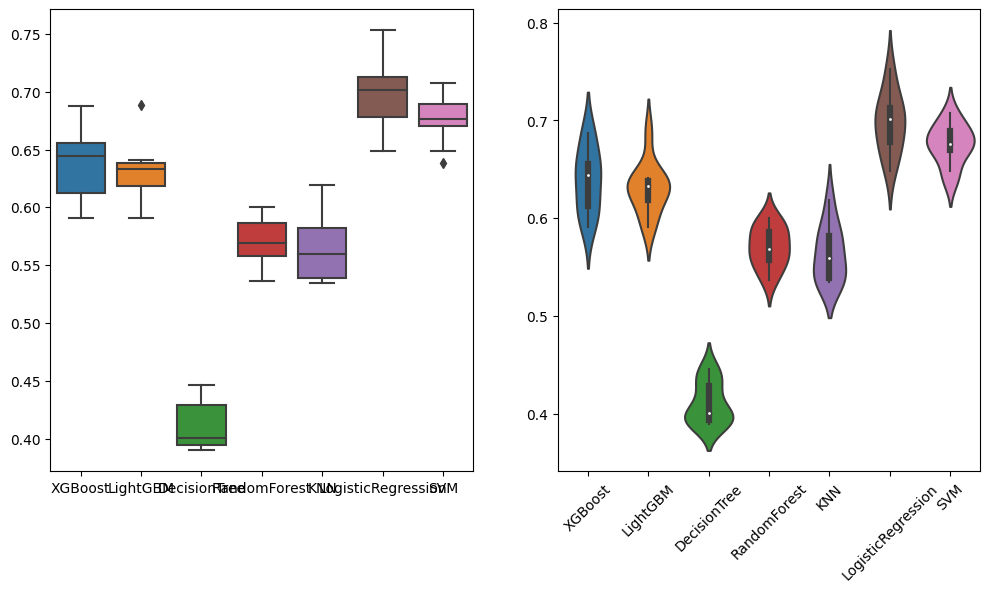

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 교차 검증 점수 데이터프레임 생성
# cv_scores = pd.DataFrame({
#     'XGBoost': xgb_cv_score,
#     'LightGBM': lgbm_cv_score,
#     'DecisionTree': dt_cv_score,
#     'RandomForest': rf_cv_score,
#     'KNN': knn_cv_score,
#     'LogisticRegression': lr_cv_score,
#     'SVM': svc_cv_score
# })

# # 박스 플롯과 바이올린 플롯 함께 사용
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# sns.boxplot(data=cv_scores, ax=axes[0])
# sns.violinplot(data=cv_scores, ax=axes[1])
# plt.xticks(rotation=45)
# plt.show()


### 3-2. Model 2 - sequence 딥러닝에 써야지

In [ ]:
# # 모델 학습
# xgb_model.fit(x_mor_sequence_train, y_train)
# lgbm_model.fit(x_mor_sequence_train, y_train)
# dt_model.fit(x_mor_sequence_train, y_train)
# rf_model.fit(x_mor_sequence_train, y_train)
# knn_model.fit(x_mor_sequence_train_re, y_train)
# lr_model.fit(x_mor_sequence_train, y_train)
# svc_model.fit(x_mor_sequence_train_re, y_train)

In [ ]:
# 성능 예측
# xgb_cv_score = cross_val_score(xgb_model, x_mor_sequence_train, y_train, cv=10)
# lgbm_cv_score = cross_val_score(lgbm_model, x_mor_sequence_train, y_train, cv=10)
# dt_cv_score = cross_val_score(dt_model, x_mor_sequence_train, y_train, cv=10)
# rf_cv_score = cross_val_score(rf_model, x_mor_sequence_train, y_train, cv=10)
# knn_cv_score = cross_val_score(knn_model, x_mor_sequence_train, y_train, cv=10)
# lr_cv_score = cross_val_score(lr_model, x_mor_sequence_train, y_train, cv=10)
# svc_cv_score = cross_val_score(svc_model, x_mor_sequence_train, y_train, cv=10)

In [ ]:
# # 결과 확인
# print('XGB :', xgb_cv_score.mean())
# print('lgbm :', lgbm_cv_score.mean())
# print('dt :', dt_cv_score.mean())
# print('rf :', rf_cv_score.mean())
# print('knn :', knn_cv_score.mean())
# print('lr :', lr_cv_score.mean())
# print('svc :', svc_cv_score.mean())


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 교차 검증 점수 데이터프레임 생성
# cv_scores = pd.DataFrame({
#     'XGBoost': xgb_cv_score,
#     'LightGBM': lgbm_cv_score,
#     'DecisionTree': dt_cv_score,
#     'RandomForest': rf_cv_score,
#     'KNN': knn_cv_score,
#     'LogisticRegression': lr_cv_score,
#     'SVM': svc_cv_score
# })

# # 박스 플롯과 바이올린 플롯 함께 사용
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# sns.boxplot(data=cv_scores, ax=axes[0])
# sns.violinplot(data=cv_scores, ax=axes[1])

# plt.show()


### 3-3. Model 3 - tfidf > n-gram > sparse

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# MultinomialNB를 사용하여 분류 모델을 학습함
clf_model = MultinomialNB()


In [ ]:
# 모델 학습
xgb_model.fit(x_tfidf_train, y_train)
lgbm_model.fit(x_tfidf_train, y_train)
dt_model.fit(x_tfidf_train, y_train)
rf_model.fit(x_tfidf_train, y_train)
knn_model.fit(x_tfidf_train_re, y_train)
lr_model.fit(x_tfidf_train, y_train)
svc_model.fit(x_tfidf_train_re, y_train)
clf_model.fit(x_tfidf_train, y_train)


MultinomialNB()

In [ ]:
# 성능 예측
xgb_cv_score = cross_val_score(xgb_model, x_tfidf_train, y_train, cv=10)
lgbm_cv_score = cross_val_score(lgbm_model, x_tfidf_train, y_train, cv=10)
dt_cv_score = cross_val_score(dt_model, x_tfidf_train, y_train, cv=10)
rf_cv_score = cross_val_score(rf_model, x_tfidf_train, y_train, cv=10)
knn_cv_score = cross_val_score(knn_model, x_tfidf_train, y_train, cv=10)
lr_cv_score = cross_val_score(lr_model, x_tfidf_train, y_train, cv=10)
svc_cv_score = cross_val_score(svc_model, x_tfidf_train, y_train, cv=10)
clf_cv_score = cross_val_score(clf_model, x_tfidf_train, y_train, cv=10)


In [ ]:
# 결과 확인
print('XGB :', xgb_cv_score.mean())
print('lgbm :', lgbm_cv_score.mean())
print('dt :', dt_cv_score.mean())
print('rf :', rf_cv_score.mean())
print('knn :', knn_cv_score.mean())
print('lr :', lr_cv_score.mean())
print('svc :', svc_cv_score.mean())
print('clf :', clf_cv_score.mean()) # naive_bayes


XGB : 0.7775809325809325
lgbm : 0.7656237006237007
dt : 0.6222096822096822
rf : 0.7301410751410751
knn : 0.7509474309474309
lr : 0.8095723195723196
svc : 0.8084244134244134
clf : 0.5875022275022275


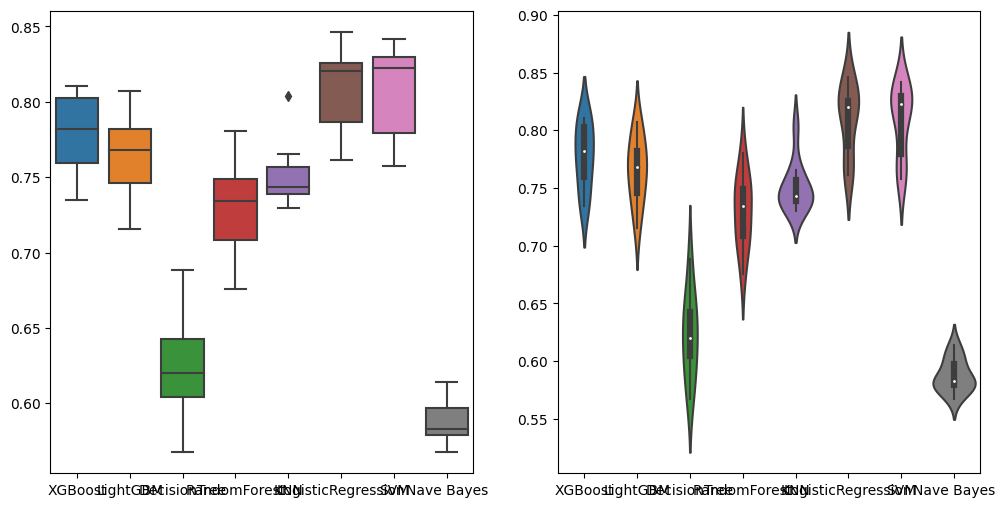

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 교차 검증 점수 데이터프레임 생성
cv_scores = pd.DataFrame({
    'XGBoost': xgb_cv_score,
    'LightGBM': lgbm_cv_score,
    'DecisionTree': dt_cv_score,
    'RandomForest': rf_cv_score,
    'KNN': knn_cv_score,
    'LogisticRegression': lr_cv_score,
    'SVM': svc_cv_score,
    'Nave Bayes': clf_cv_score
})

# 박스 플롯과 바이올린 플롯 함께 사용
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.boxplot(data=cv_scores, ax=axes[0])
sns.violinplot(data=cv_scores, ax=axes[1])

plt.show()


### 3-4. Hyperparameter Tuning(Optional) 
* Manual Search, Grid search, Bayesian Optimization, TPE...
> * [grid search tutorial sklearn](https://scikit-learn.org/stable/modules/grid_search.html)
> * [optuna tutorial](https://optuna.org/#code_examples)
> * [ray-tune tutorial](https://docs.ray.io/en/latest/tune/examples/tune-sklearn.html)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Grid Search 선언
param = {'max_depth': range(21, 50)} 
  
xgb_grid_model = GridSearchCV(xgb_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

lgbm_grid_model = GridSearchCV(lgbm_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

dt_grid_model = GridSearchCV(dt_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

rf_grid_model = GridSearchCV(rf_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

knn_grid_model = GridSearchCV(knn_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

lr_grid_model = GridSearchCV(lr_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

svc_grid_model = GridSearchCV(svc_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )
clf_grid_model = GridSearchCV(clf_model,   # 기본 모델 이름
                     param,       # 앞에서 선언한 튜닝용 파라미터 변수
                     cv = 5,      # k-fold Cross validation(default = 5)
                     scoring='f1' # 평가 방법
                     )

In [ ]:
# 학습하기
xgb_grid_model.fit(x_tfidf_train, y_train)
lgbm_grid_model.fit(x_tfidf_train, y_train)
dt_grid_model.fit(x_tfidf_train, y_train)
rf_grid_model.fit(x_tfidf_train, y_train)
knn_grid_model.fit(x_tfidf_train_re, y_train)
lr_grid_model.fit(x_tfidf_train, y_train)
svc_grid_model.fit(x_tfidf_train_re, y_train)
clf_grid_model.fit(x_tfidf_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py", line 1287, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  File "/usr/local/lib/pyt

In [ ]:
# 중요 정보 확인
# print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('xgb 최적파라미터:', xgb_grid_model.best_params_)
print('xgb 최고성능:', xgb_grid_model.best_score_)
print('=' * 80)
print('lgbm 최적파라미터:', lgbm_grid_model.best_params_)
print('lgbm 최고성능:', lgbm_grid_model.best_score_)
print('=' * 80)
print('dt 최적파라미터:', dt_grid_model.best_params_)
print('dt 최고성능:', dt_grid_model.best_score_)
print('=' * 80)
print('rf 최적파라미터:', rf_grid_model.best_params_)
print('rf 최고성능:', rf_grid_model.best_score_)
print('=' * 80)
print('knn 최적파라미터:', knn_grid_model.best_params_)
print('knn 최고성능:', knn_grid_model.best_score_)
print('=' * 80)
print('lr 최적파라미터:', lr_grid_model.best_params_)
print('lr 최고성능:', lr_grid_model.best_score_)
print('=' * 80)
print('svc 최적파라미터:', svc_grid_model.best_params_)
print('svc 최고성능:', svc_grid_model.best_score_)
print('=' * 80)
print('clf 최적파라미터:', clf_grid_model.best_params_)
print('clf 최고성능:', clf_grid_model.best_score_)
print('=' * 80)

## 성능 평가

- w2v

In [ ]:
# x_pr_val.drop('Unnamed: 0', axis=1, inplace=True)


In [ ]:
# 예측하기
# xgb_y_pred = xgb_grid_model.predict(x_pr_val)
# lgbm_y_pred = lgbm_grid_model.predict(x_pr_val)
# dt_y_pred = dt_grid_model.predict(x_pr_val)
# rf_y_pred = rf_grid_model.predict(x_pr_val)
# knn_y_pred = knn_grid_model.predict(x_pr_val)
# lr_y_pred = lr_grid_model.predict(x_pr_val)
# svc_y_pred = svc_grid_model.predict(x_pr_val)

In [ ]:
# xgb_y_pred


In [ ]:
# xgb_y_pred = pd.DataFrame({'id': x_pr_val.index, 'label' : xgb_y_pred})
# xgb_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

# lgbm_y_pred = pd.DataFrame({'id': x_pr_val.index, 'label' : lgbm_y_pred})
# lgbm_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

# dt_y_pred = pd.DataFrame({'id': x_pr_val.index, 'label' : dt_y_pred})
# dt_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

# rf_y_pred = pd.DataFrame({'id': x_pr_val.index, 'label' : rf_y_pred})
# rf_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

In [ ]:
# lgbm_y_pred

In [ ]:
# xgb_y_pred.to_csv('xgb_y_pred_성능튜닝.csv', index=False)
# lgbm_y_pred.to_csv('lgbm_y_pred_성능튜닝.csv', index=False)
# dt_y_pred.to_csv('dt_y_pred_성능튜닝.csv', index=False)
# rf_y_pred.to_csv('rf_y_pred_성능튜닝.csv', index=False)


- n-gram

In [ ]:

# x_tfidf_val.drop('Unnamed: 0', axis=1, inplace=True)


In [ ]:
# 예측하기
xgb_y_pred = xgb_grid_model.predict(x_tfidf_val)
lgbm_y_pred = lgbm_grid_model.predict(x_tfidf_val)
dt_y_pred = dt_grid_model.predict(x_tfidf_val)
rf_y_pred = rf_grid_model.predict(x_tfidf_val)
knn_y_pred = knn_grid_model.predict(x_tfidf_val)
lr_y_pred = lr_grid_model.predict(x_tfidf_val)
svc_y_pred = svc_grid_model.predict(x_tfidf_val)
clf_y_pred = clf_grid_model.predict(x_tfidf_val)

In [ ]:
xgb_y_pred


In [ ]:
xgb_y_pred = pd.DataFrame({'id': x_tfidf_val.index, 'label' : xgb_y_pred})
xgb_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

lgbm_y_pred = pd.DataFrame({'id': x_tfidf_val.index, 'label' : lgbm_y_pred})
lgbm_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

dt_y_pred = pd.DataFrame({'id': x_tfidf_val.index, 'label' : dt_y_pred})
dt_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

rf_y_pred = pd.DataFrame({'id': x_tfidf_val.index, 'label' : rf_y_pred})
rf_y_pred['label'].replace([0, 1, 2, 3, 4], ['코드', '웹', '이론', '시스템 운영', '원격'] , inplace=True)

In [ ]:
lgbm_y_pred

In [ ]:
# xgb_y_pred.to_csv('xgb_y_pred_성능튜닝.csv', index=False)
# lgbm_y_pred.to_csv('lgbm_y_pred_성능튜닝.csv', index=False)
# dt_y_pred.to_csv('dt_y_pred_성능튜닝.csv', index=False)
# rf_y_pred.to_csv('rf_y_pred_성능튜닝.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt

def compare_models_accuracy(y_true, y_preds, model_names):
    """
    각 모델의 예측 결과값과 이름을 받아 정확도를 시각화하는 함수
    
    Parameters
    ----------
    y_true : pandas.Series
        실제 레이블 값
    y_preds : list of pandas.Series
        각 모델의 예측 결과값들
    model_names : list of str
        각 모델의 이름들
        
    Returns
    -------
    None
    """
    # 각 모델의 정확도를 계산하여 리스트에 저장
    accuracies = [accuracy_score(y_true, y_pred) for y_pred in y_preds]

    # 선 그래프로 시각화
    plt.plot(model_names, accuracies, marker='o', markersize=8)

    # 그래프 제목과 축 라벨 설정
    plt.title('Accuracy Comparison', fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)

    # x축 눈금 라벨 각도와 폰트 크기 설정
    plt.xticks(rotation=30, fontsize=10)

    # y축 눈금 범위 설정
    plt.ylim(0.7, 1.0)

    # 그리드 라인 추가
    plt.grid(True)

    # 그래프 저장 및 출력
    plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# 예측하기
xgb_y_pred = xgb_grid_model.predict(x_tfidf_val)
lgbm_y_pred = lgbm_grid_model.predict(x_tfidf_val)
dt_y_pred = dt_grid_model.predict(x_tfidf_val)
rf_y_pred = rf_grid_model.predict(x_tfidf_val)
knn_y_pred = knn_grid_model.predict(x_tfidf_val)
lr_y_pred = lr_grid_model.predict(x_tfidf_val)
svc_y_pred = svc_grid_model.predict(x_tfidf_val)

# 각 모델의 예측 결과값을 DataFrame으로 변환
y_preds = [pd.Series(xgb_y_pred),
           pd.Series(lgbm_y_pred),
           pd.Series(dt_y_pred),
           pd.Series(rf_y_pred),
           pd.Series(knn_y_pred),
           pd.Series(lr_y_pred),
           pd.Series(svc_y_pred),
           pd.Series(clf_y_pred)]

# 각 모델의 이름을 리스트에 저장
model_names = ['XGBoost', 'LightGBM', 'Decision Tree', 'Random Forest', 'KNN', 'Logistic Regression', 'SVC', 'Naive Bayes']

# 시각화 함수 실행
compare_models_accuracy(y_val, y_preds, model_names)


## 4. Deep Learning(Sequence)
* Sequence로 전처리한 데이터를 이용하여 DNN, 1-D CNN, LSTM 등 3가지 이상의 deep learning 모델 학습 및 성능 분석
> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)

### 4-1. DNN

### 4-2. 1-D CNN

### 4-3. LSTM

## 5. Using pre-trained model(Optional)
* 한국어 pre-trained model로 fine tuning 및 성능 분석
> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
> * [HuggingFace-Korean](https://huggingface.co/models?language=korean)

## KoBert

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()